<a href="https://colab.research.google.com/github/RayGone/SentimentAnalysis/blob/phase2/Experiments/Embedding_As_Feature/BERT%26GPT_Embedding_As_Feature_4SA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers tokenizers datasets huggingface_hub --quiet

import numpy as np
import random
import os
import tensorflow as tf
from transformers import set_seed

rand_seed = 9

def seed_everything(seed=0):
    random.seed(seed) # random
    os.environ['PYTHONHASHSEED'] = str(seed) # python enviroment
    np.random.seed(seed) # numpy
    tf.keras.utils.set_random_seed(seed) # tensorflow
    tf.random.set_seed(seed) # tensorflow
    set_seed(seed) # hugging_face transformer

seed_everything(rand_seed)

## Loading Transformers

In [ ]:
from transformers import PreTrainedTokenizerFast, BertTokenizerFast, TFAutoModel
import datasets

gptModel = 'raygx/GNePT-NepSA'
gptTokenizer = PreTrainedTokenizerFast.from_pretrained(gptModel,padding_side='left')
gptModel = TFAutoModel.from_pretrained(gptModel)

bertModel = 'raygx/BERT-NepSA-T2'
bertTokenizer = BertTokenizerFast.from_pretrained(bertModel)
bertModel = TFAutoModel.from_pretrained(bertModel)

gptModel.config, bertModel.config

Some layers from the model checkpoint at raygx/GNePT-NepSA were not used when initializing TFGPT2Model: ['score']
- This IS expected if you are initializing TFGPT2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFGPT2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFGPT2Model were initialized from the model checkpoint at raygx/GNePT-NepSA.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2Model for predictions without further training.


Some layers from the model checkpoint at raygx/BERT-NepSA-T2 were not used when initializing TFBertModel: ['classifier', 'dropout_37']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at raygx/BERT-NepSA-T2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


(GPT2Config {
   "_name_or_path": "raygx/GNePT-NepSA",
   "activation_function": "gelu_new",
   "architectures": [
     "GPT2ForSequenceClassification"
   ],
   "attn_pdrop": 0.1,
   "bos_token_id": null,
   "embd_pdrop": 0.1,
   "eos_token_id": null,
   "id2label": {
     "0": "NEUTRAL",
     "1": "POSITIVE",
     "2": "NEGATIVE"
   },
   "initializer_range": 0.02,
   "label2id": {
     "NEGATIVE": 2,
     "NEUTRAL": 0,
     "POSITIVE": 1
   },
   "layer_norm_epsilon": 1e-05,
   "model_type": "gpt2",
   "n_ctx": 1024,
   "n_embd": 768,
   "n_head": 12,
   "n_inner": null,
   "n_layer": 12,
   "n_positions": 1024,
   "pad_token_id": 3,
   "reorder_and_upcast_attn": false,
   "resid_pdrop": 0.1,
   "scale_attn_by_inverse_layer_idx": false,
   "scale_attn_weights": true,
   "summary_activation": null,
   "summary_first_dropout": 0.1,
   "summary_proj_to_labels": true,
   "summary_type": "cls_index",
   "summary_use_proj": true,
   "task_specific_params": {
     "text-generation": {
     

## Loading Data

In [ ]:
print("#######################Using NepCov19Tweets#########################")
data = datasets.load_dataset("raygx/NepCov19TweetsPlus")

data = data.rename_columns({"Sentiment":"label","Sentences":"text"})
data

#######################Using NepCov19Tweets#########################


DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 41541
    })
})

In [ ]:
data = data.shuffle(rand_seed)
data = data['train'].train_test_split(test_size=0.2)
data

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 33232
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 8309
    })
})

In [ ]:
def prepareLabels(row):
    if row['label'] == -1:
        row['label'] = 2

    return row

data = data.map(
        prepareLabels,
        num_proc=4)

data

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 33232
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 8309
    })
})

## Creating Embedding Layer

In [ ]:
import tensorflow as tf

class GPTEmbedding(tf.keras.layers.Layer):
  def __init__(self, model,tokenizer, max_token_len=128,padding='max_length',trailing_context=4,truncation=True):
    super().__init__()
    self.embedding = model
    self.tokenizer = tokenizer
    self.tokenizer.padding_side = 'left'
    self.max_token = max_token_len
    self.padding = padding
    self.truncation = truncation
    self.trailing_context = trailing_context
    self.trainable=False

  def call(self, x):
    embeddings = self.embedding(
                  self.tokenizer(x,padding=self.padding,truncation=self.truncation,max_length=self.max_token,return_tensors='tf')
                )[0][:,-self.trailing_context:,:]

    return tf.reduce_logsumexp(embeddings,axis=1)

class BERTEmbedding(tf.keras.layers.Layer):
  def __init__(self, model,tokenizer, max_token_len=128,padding='max_length',truncation=True):
    super().__init__()
    self.embedding = model
    self.tokenizer = tokenizer
    self.max_token = max_token_len
    self.padding = padding
    self.truncation = truncation
    self.trainable=False

  def call(self, x):
    return self.embedding(self.tokenizer(x,padding=self.padding,truncation=self.truncation,max_length=self.max_token,return_tensors='tf'))[1]

In [ ]:
# model.bert(tokenizer('बैंक तथा वित्तीय संस्थामा देखिएको विश्वासको',padding='max_length',truncation=True,return_tensors='tf',max_length=128))
gpt_embd = GPTEmbedding(gptModel.transformer,gptTokenizer,max_token_len=100,trailing_context=4)
bert_embd = BERTEmbedding(bertModel.bert,bertTokenizer,max_token_len=100)
# embd(["",'बैंक तथा वित्तीय संस्थामा देखिएको विश्वासको','बैंक तथा वित्तीय संस्थामा देखिएको विश्वासको'])
d_model = tf.concat([gpt_embd(["abcd",'efgh']),bert_embd(["abcd",'efgh'])],axis=1).shape[1]
d_model

1536

## Creating Data Generator

In [ ]:
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, data,model_dim, batch_size=32,shuffle=True):
        'Initialization'
        self.batch_size = batch_size
        self.data = data
        self.embeddings = np.empty((data.num_rows,model_dim))
        self.shuffle = shuffle
        # self.average = tf.keras.layers.Average()
        self.is_first_epoch = True
        self.on_epoch_end(is_first_epoch=self.is_first_epoch)

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.ceil(self.data.num_rows / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        return self.__data_generation(indexes)

    def on_epoch_end(self,is_first_epoch=False):
        'Updates indexes after each epoch'
        self.indexes = np.arange(self.data.num_rows)
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

        self.is_first_epoch = is_first_epoch


    def __data_generation(self, indexes):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        chunk = self.data.select(indexes)

        if self.is_first_epoch:
          X = tf.concat([gpt_embd(chunk['text']), bert_embd(chunk['text'])],axis=1)
          self.embeddings[indexes] = X
        else:
          X = self.embeddings[indexes]

        y = np.array(chunk['label'])
        return X,y

In [ ]:
%%time

train_features = DataGenerator(data['train'],model_dim=d_model,batch_size=32)
test_features = DataGenerator(data['test'],model_dim=d_model,shuffle=False)

CPU times: user 659 µs, sys: 0 ns, total: 659 µs
Wall time: 655 µs


## Classification Head

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(d_model)),
    tf.keras.layers.Dense(768,activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(3,activation='softmax')
])

model.compile(
  optimizer=tf.keras.optimizers.Adam(
        learning_rate=5e-4,
        weight_decay=0.1
      ),
  loss='sparse_categorical_crossentropy',
  metrics=['acc'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 768)               1180416   
                                                                 
 dropout_77 (Dropout)        (None, 768)               0         
                                                                 
 dense_7 (Dense)             (None, 3)                 2307      
                                                                 
Total params: 1,182,723
Trainable params: 1,182,723
Non-trainable params: 0
_________________________________________________________________


## Training Classification

In [ ]:
history = model.fit(train_features,
        epochs=100,
        validation_data=test_features,
        callbacks=[tf.keras.callbacks.EarlyStopping(
                            monitor='val_acc', patience=3,
                            verbose=1, mode='auto',
                            restore_best_weights=True)
                        ])

Epoch 1/100
1039/1039 [==============================] - 18s 16ms/step - loss: 0.4365 - acc: 0.8391 - val_loss: 0.3861 - val_acc: 0.8526
Epoch 2/100
1039/1039 [==============================] - 12s 12ms/step - loss: 0.3825 - acc: 0.8498 - val_loss: 0.3887 - val_acc: 0.8481
Epoch 3/100
1039/1039 [==============================] - 8s 8ms/step - loss: 0.3801 - acc: 0.8508 - val_loss: 0.3788 - val_acc: 0.8565
Epoch 4/100
1039/1039 [==============================] - 8s 8ms/step - loss: 0.3757 - acc: 0.8515 - val_loss: 0.3907 - val_acc: 0.8521
Epoch 5/100
1039/1039 [==============================] - 9s 8ms/step - loss: 0.3757 - acc: 0.8521 - val_loss: 0.3817 - val_acc: 0.8537
Epoch 6/100
1039/1039 [==============================] - 7s 7ms/step - loss: 0.3747 - acc: 0.8520 - val_loss: 0.3961 - val_acc: 0.8472
Epoch 6: early stopping


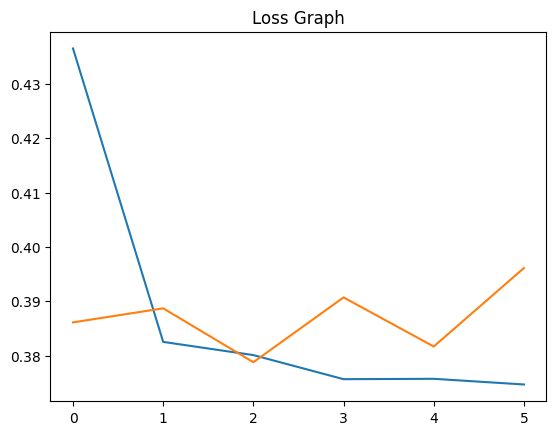

Text(0.5, 1.0, 'Accuracy Graph')

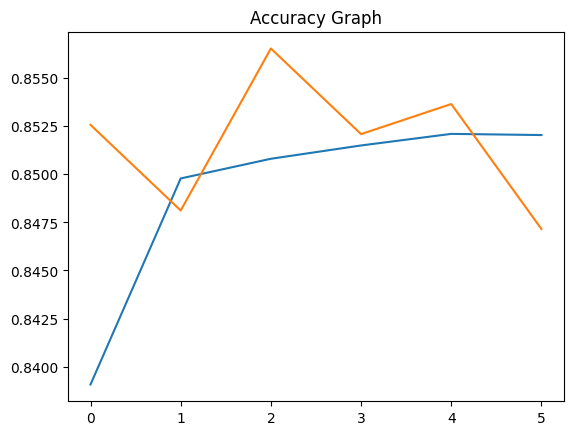

In [ ]:
import seaborn
from matplotlib import pyplot as plt

seaborn.lineplot(history.history['loss'])
seaborn.lineplot(history.history['val_loss'])
plt.title("Loss Graph")
plt.show()

seaborn.lineplot(history.history['acc'])
seaborn.lineplot(history.history['val_acc'])
plt.title("Accuracy Graph")

## Model Evaluation

In [ ]:
%%time
print("Getting Test Prediction")
pred_labels = [np.argmax(x) for x in model.predict(test_features)]

actual_labels = data['test']['label']

Getting Test Prediction
260/260 [==============================] - 1s 4ms/step
CPU times: user 1.25 s, sys: 73.3 ms, total: 1.32 s
Wall time: 1.18 s


In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

print("F1-Score",f1_score(actual_labels,pred_labels,average='weighted'))
print("Precision-Score",precision_score(actual_labels,pred_labels,average='weighted'))
print("Recall-Score",recall_score(actual_labels,pred_labels,average='weighted'))
print("accuracy_Score",accuracy_score(actual_labels,pred_labels))

F1-Score 0.856621487668053
Precision-Score 0.8570253528906139
Recall-Score 0.8565411000120351
accuracy_Score 0.8565411000120351


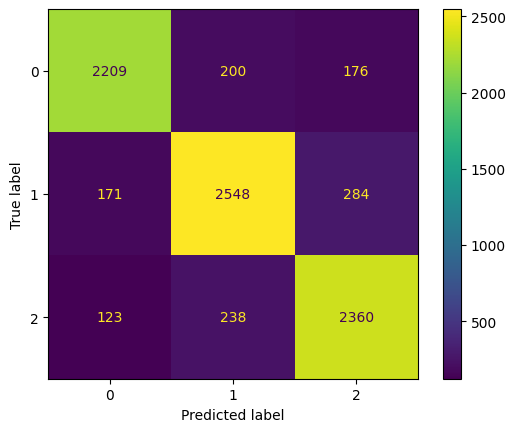

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cmd = ConfusionMatrixDisplay(tf.math.confusion_matrix(actual_labels,pred_labels,num_classes=3).numpy())
cmd.plot()